In [2]:
from torch.utils.data import DataLoader, random_split

In [4]:
import torchvision 
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# Load Weights
weights = ResNet18_Weights.DEFAULT  
transforms = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [9]:
dataset = ImageFolder("/kaggle/input/plantdisease/PlantVillage", transform=transforms)

In [10]:
# Split Dataset 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(f"TrainSize {train_size}, Test Size: {test_size}")

TrainSize 16510, Test Size: 4128


In [11]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

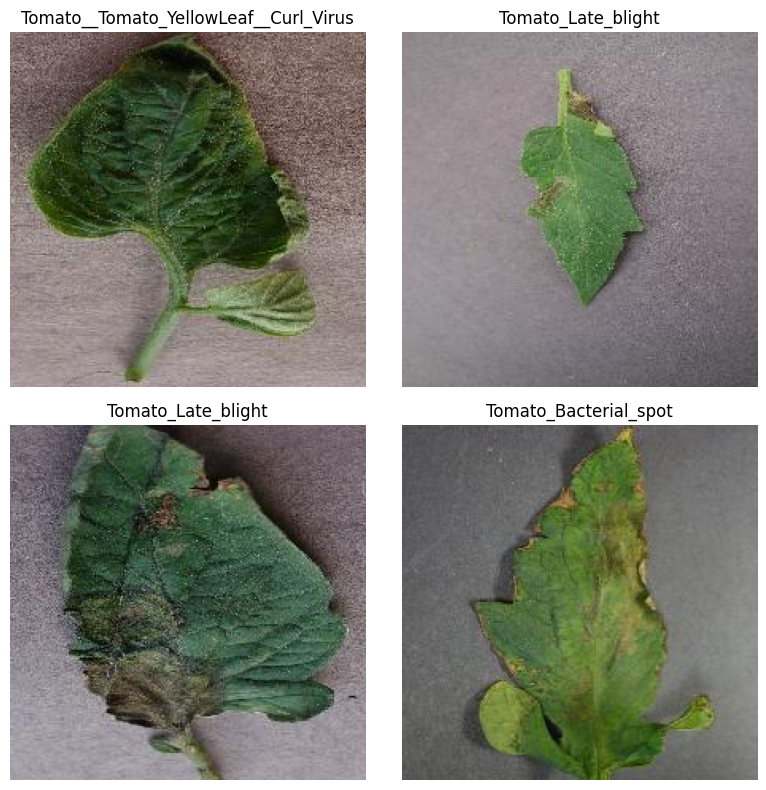

In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

def unnormalize(img): 
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean
    
def imshow(img, title=None):
    img = unnormalize(img)
    img = img.numpy().transpose((1, 2, 0))  # CHW to HWC
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

class_names = dataset.classes  # Get class names from dataset
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i]])
plt.tight_layout()
plt.show()

In [13]:
import torch.nn as nn 
import torch.optim as optim

In [25]:
num_classes = len(dataset.classes)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes) # modify output => num_classes
model = model.to(device)

In [27]:
# Loss and Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Training Loop 
num_epochs = 25 

for epoch in range(num_epochs): 
    model.train() 
    total_loss = 0
    correct = 0 
    total = 0

    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item() 
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/25], Loss: 893.2267, Accuracy: 43.22%
Epoch [2/25], Loss: 420.1647, Accuracy: 72.64%
Epoch [3/25], Loss: 283.1910, Accuracy: 81.23%
Epoch [4/25], Loss: 216.6452, Accuracy: 85.77%
Epoch [5/25], Loss: 176.7096, Accuracy: 88.33%
Epoch [6/25], Loss: 142.5758, Accuracy: 90.57%
Epoch [7/25], Loss: 113.0399, Accuracy: 92.49%
Epoch [8/25], Loss: 99.4452, Accuracy: 93.26%
Epoch [9/25], Loss: 87.0927, Accuracy: 94.15%
Epoch [10/25], Loss: 69.8737, Accuracy: 95.29%
Epoch [11/25], Loss: 60.1230, Accuracy: 95.86%
Epoch [12/25], Loss: 58.5927, Accuracy: 95.98%
Epoch [13/25], Loss: 45.8293, Accuracy: 96.94%
Epoch [14/25], Loss: 46.0113, Accuracy: 96.96%
Epoch [15/25], Loss: 44.2477, Accuracy: 97.00%
Epoch [16/25], Loss: 35.3229, Accuracy: 97.58%
Epoch [17/25], Loss: 36.3130, Accuracy: 97.44%
Epoch [18/25], Loss: 27.8482, Accuracy: 98.12%
Epoch [19/25], Loss: 30.2637, Accuracy: 97.99%
Epoch [20/25], Loss: 29.8463, Accuracy: 98.19%
Epoch [21/25], Loss: 27.8124, Accuracy: 98.19%
Epoch [22/25], 

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
torch.save(model.state_dict(), 'resnet18_custom.pth')
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report (includes precision, recall, f1-score per class)
target_names = dataset.classes  # Uses folder names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Confusion Matrix:
[[213   3   0   0   0   0   0   2   0   0   0   0   3   0   0]
 [  0 289   0   0   1   0   0   1   0   0   0   0   1   0   0]
 [  0   0 220   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   3 186   0   0   4  23   0   0   0   0   0   0   0]
 [  0   0   0   0  23   0   0   1   0   0   0   0   1   0   0]
 [  0   1   1   0   0 392   1   2   0   6   0   0   5   0   0]
 [  1   0   1   0   0   0 193  11   1   1   1   3   0   1   0]
 [  0   1   2   0   0   0   3 364   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0 178   3   1   1   1   0   0]
 [  3   0   3   0   0   0   1   1   0 333   0   1   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0 290   7   2   4   0]
 [  0   0   0   0   0   0   2   0   0   4  11 281   0   4   0]
 [  0   0   0   0   0   1   0   1   0   0   2   0 669   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  64   0]
 [  0   0   0   0   0   0   0   1   0   0   0   5   0   0 285]]

Classification Report:
            

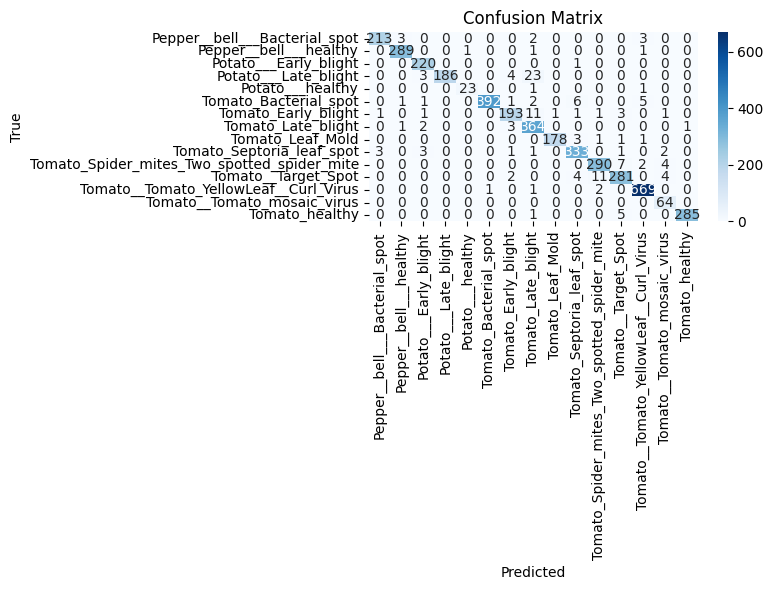

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [32]:
torch.save(model.state_dict(), 'resnet18_custom.pth')